In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import xarray as xr

from aospy import Proj, Model, Run, Var, Region, Calc, CalcInterface
from aospy.data_loader import DictDataLoader
%matplotlib inline

Define example aospy objects
----------------------------

In [2]:
def total_precipitation(convection_rain, condensation_rain):
    return convection_rain + condensation_rain

In [3]:
files = os.path.normpath('../aospy/test/data/netcdf/000[4-6]0101.precip_monthly.nc')
file_map = {'monthly': files}
example_run = Run(
    name='example_run',
    description=(
        'Control simulation of the idealized moist model'
    ),
    data_loader=DictDataLoader(file_map)
)


In [4]:
example_model = Model(
    name='example_model',
    grid_file_paths=(
        os.path.normpath('../aospy/test/data/netcdf/00040101.precip_monthly.nc'),
        os.path.normpath('../aospy/test/data/netcdf/im.landmask.nc')
    ),
    runs=[example_run]
)

In [5]:
example_proj = Proj(
    'example_proj',
    direc_out='example-output',
    tar_direc_out='example-tar-output',
    models=(example_model,)
)

Initializing Project instance: example_proj (Thu Jan 19 20:01:27 2017)


In [6]:
condensation_rain = Var(
    name='condensation_rain',
    alt_names=('prec_ls',),
    def_time=True,
    description=('condensation rain'),
)

convection_rain = Var(
    name='convection_rain',
    alt_names=('prec_conv',),
    def_time=True,
    description=('convection rain'),
)

precip = Var(
    name='total_precipitation',
    def_time=True,
    description=('total precipitation rate'),
    func=total_precipitation,
    variables=(convection_rain, condensation_rain)
)

In [7]:
globe = Region(
    name='globe',
    description='Entire globe',
    lat_bounds=(-90, 90),
    lon_bounds=(0, 360),
    do_land_mask=False
)

Compute annual mean total precipitation rate
----------------------------------------------

In [8]:
calc_int = CalcInterface(
    proj=example_proj,
    model=example_model,
    run=example_run,
    var=precip,
    date_range=(datetime(4, 1, 1), datetime(6, 12, 31)),
    intvl_in='monthly',
    dtype_in_time='ts',
    intvl_out='ann',
    dtype_out_time='av'
)
Calc(calc_int).compute()

/home/skc/aospy/aospy/utils/times.py:198: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  min_yr_decoded = xr.decode_cf(time.to_dataset('dummy'))
/nbhome/skc/anaconda2/lib/python2.7/site-packages/xarray/conventions.py:377: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/nbhome/skc/anaconda2/lib/python2.7/site-packages/xarray/conventions.py:396: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [9]:
ds = xr.open_dataset(calc_int.path_out['av'])

In [10]:
ds

<xarray.Dataset>
Dimensions:              (lat: 64, lon: 128)
Coordinates:
  * lon                  (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 ...
  * lat                  (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 ...
    avg_start_date       datetime64[ns] 1678-01-01
    avg_end_date         datetime64[ns] 1681-01-01
    sfc_area             (lat, lon) float64 3.553e+09 3.553e+09 3.553e+09 ...
    land_mask            (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Data variables:
    total_precipitation  (lat, lon) float64 5.158e-06 5.147e-06 5.136e-06 ...

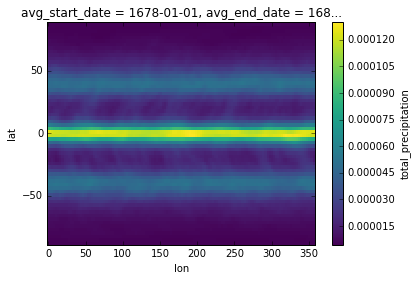

In [11]:
ds.total_precipitation.plot()

In [12]:
# The path to the output in this example is given by
calc_int.path_out['av']

'example-output/example_proj/example_model/example_run/total_precipitation/total_precipitation.ann.av.from_monthly_ts.example_model.example_run.0004-0006.nc'

Compute global annual mean total precipitation rate
---------------------------------------------------

In [13]:
calc_int = CalcInterface(
    proj=example_proj,
    model=example_model,
    run=example_run,
    var=precip,
    date_range=(datetime(4, 1, 1), datetime(6, 12, 31)),
    intvl_in='monthly',
    dtype_in_time='ts',
    intvl_out='ann',
    dtype_out_time='reg.av',
    region={'globe': globe}
)
Calc(calc_int).compute()

In [14]:
calc_int.path_out['reg.av']

'example-output/example_proj/example_model/example_run/total_precipitation/total_precipitation.ann.reg.av.from_monthly_ts.example_model.example_run.0004-0006.nc'

In [15]:
ds = xr.open_dataset(calc_int.path_out['reg.av'])

In [16]:
ds

<xarray.Dataset>
Dimensions:         ()
Coordinates:
    avg_start_date  datetime64[ns] 1678-01-01
    avg_end_date    datetime64[ns] 1681-01-01
Data variables:
    globe           float64 3.501e-05